In [1]:
import os
import numpy as np
import mne
import pickle
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from pykalman import KalmanFilter
from joblib import Parallel, delayed
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# test patients 
data_dir = "preprocessed_epochs"
test_patients_sd = ["52", "18", "29", "17", "34", "55","10", "22", "68", "19", "42", "63"]
test_patients_ns = ["01", "19", "30", "65", "10", "13", "25", "69", "24", "33", "38", "67"]


In [16]:
test_sessions = []
for patient in test_patients_ns:
    test_sessions.append((patient, "1"))
for patient in test_patients_sd:
    test_sessions.append((patient, "2"))

def process_epoch_em(epoch, n_components, n_iter):
    """
    Apply PCA to reduce dimensionality, then use Kalman Filter with EM to estimate parameters.
    """
    # Apply PCA (variance percentage?)
    pca = PCA(n_components=n_components)
    reduced_epoch = pca.fit_transform(epoch.T)  
    kf = KalmanFilter(
        transition_matrices=np.eye(n_components),  # Initial guess for transition matrix
        observation_matrices=np.eye(n_components), 
        transition_covariance=np.eye(n_components) * 1e-4,  # Small regularization, did not converge without this 
        observation_covariance=np.eye(n_components) * 1e-4 
    )

    kf = kf.em(reduced_epoch, n_iter=n_iter)

    smoothed_state_means, _ = kf.smooth(reduced_epoch)
    return smoothed_state_means.T  

smoothed_data_dict = {}

for file_name in os.listdir(data_dir):
    if not file_name.endswith(".fif"):
        continue

    patient_id = file_name.split("_")[0].split("-")[1]
    session = file_name.split("_")[1].split("-")[1]

    file_path = os.path.join(data_dir, file_name)
    epochs = mne.read_epochs(file_path, preload=True)

    # skip patients with less than 10 epochs, too little data, may skew results 
    if len(epochs) < 10:
        continue

    # parallel
    smoothed_epochs = Parallel(n_jobs=14)(
        delayed(process_epoch_em)(epoch, n_components = 25, n_iter=7) for epoch in epochs.get_data()
    )

    smoothed_data_dict[f"{patient_id}_ses-{session}"] = {
        "smoothed_data": np.array(smoothed_epochs), 
        "label": 0 if session == "1" else 1  # 0 = NS, 1 = SD
    }

    smoothed_data = np.array(smoothed_epochs)  
    print(f"Processed {file_name}: {smoothed_data.shape}")

output_file = "KF_smoothed_data.pkl"
with open(output_file, "wb") as f:
    pickle.dump(smoothed_data_dict, f)

print(f"Saved smoothed data to {output_file}.")

Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-01_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-01_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-01_ses-1_retained-epochs.fif: (75, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-01_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-01_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-01_ses-2_retained-epochs.fif: (56, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-02_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-02_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-02_ses-1_retained-epochs.fif: (69, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-02_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-02_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-02_ses-2_retained-epochs.fif: (67, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-03_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-03_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-03_ses-1_retained-epochs.fif: (70, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-03_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-03_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-03_ses-2_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-04_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-04_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-04_ses-2_retained-epochs.fif: (48, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-05_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-05_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-05_ses-1_retained-epochs.fif: (75, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-05_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-05_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-05_ses-2_retained-epochs.fif: (75, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-06_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-06_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-06_ses-1_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-06_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-06_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-06_ses-2_retained-epochs.fif: (66, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-07_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-07_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-07_ses-1_retained-epochs.fif: (71, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-07_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-07_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-07_ses-2_retained-epochs.fif: (39, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-08_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-08_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-08_ses-1_retained-epochs.fif: (38, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-08_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-08_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-08_ses-2_retained-epochs.fif: (58, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-09_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-09_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-09_ses-1_retained-epochs.fif: (33, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-09_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-09_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-09_ses-2_retained-epochs.fif: (41, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-10_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-10_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-10_ses-1_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-10_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-10_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-10_ses-2_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-11_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-11_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-11_ses-1_retained-epochs.fif: (48, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-11_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-11_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-11_ses-2_retained-epochs.fif: (66, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-12_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-12_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-12_ses-1_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-12_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-12_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-12_ses-2_retained-epochs.fif: (68, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-13_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-13_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-13_ses-1_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-13_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-14_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-13_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-14_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-14_ses-1_retained-epochs.fif: (67, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-14_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-14_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-14_ses-2_retained-epochs.fif: (70, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-15_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-15_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-15_ses-1_retained-epochs.fif: (65, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-15_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-15_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-15_ses-2_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-16_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-16_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-16_ses-1_retained-epochs.fif: (71, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-16_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-16_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-16_ses-2_retained-epochs.fif: (68, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-17_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-17_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-17_ses-1_retained-epochs.fif: (68, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-17_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-17_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-17_ses-2_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-18_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-18_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-18_ses-1_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-18_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-18_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-18_ses-2_retained-epochs.fif: (75, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-19_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-19_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-19_ses-1_retained-epochs.fif: (75, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-19_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-19_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-19_ses-2_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-20_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-20_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-20_ses-1_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-20_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-20_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-20_ses-2_retained-epochs.fif: (58, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-21_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-21_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-21_ses-1_retained-epochs.fif: (45, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-21_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-21_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-21_ses-2_retained-epochs.fif: (49, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-22_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-22_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-22_ses-1_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-22_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-22_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-22_ses-2_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-23_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-23_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-23_ses-1_retained-epochs.fif: (70, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-23_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-23_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-23_ses-2_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-24_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-24_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-24_ses-1_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-24_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-24_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-24_ses-2_retained-epochs.fif: (50, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-25_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-25_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-25_ses-1_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-25_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-25_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-25_ses-2_retained-epochs.fif: (69, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-26_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-26_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-26_ses-1_retained-epochs.fif: (75, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-26_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-26_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-26_ses-2_retained-epochs.fif: (75, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-27_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-27_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-27_ses-1_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-27_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-27_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-27_ses-2_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-28_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-28_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-28_ses-1_retained-epochs.fif: (54, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-28_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-29_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-28_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-29_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-29_ses-1_retained-epochs.fif: (31, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-29_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-29_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-29_ses-2_retained-epochs.fif: (75, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-30_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-30_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-30_ses-1_retained-epochs.fif: (75, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-30_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-30_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-30_ses-2_retained-epochs.fif: (42, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-31_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-31_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-31_ses-1_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-31_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-31_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-31_ses-2_retained-epochs.fif: (68, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-32_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-32_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-32_ses-1_retained-epochs.fif: (62, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-32_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-32_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-32_ses-2_retained-epochs.fif: (17, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-33_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-33_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-33_ses-1_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-33_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-33_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-33_ses-2_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-34_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-34_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-34_ses-1_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-34_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-34_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-34_ses-2_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-35_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-35_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-35_ses-1_retained-epochs.fif: (43, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-35_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-35_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-35_ses-2_retained-epochs.fif: (69, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-36_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-36_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-36_ses-1_retained-epochs.fif: (49, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-36_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-36_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-36_ses-2_retained-epochs.fif: (75, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-37_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-37_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-37_ses-1_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-37_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-37_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-37_ses-2_retained-epochs.fif: (41, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-38_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-38_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-38_ses-1_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-39_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-39_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-39_ses-1_retained-epochs.fif: (17, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-39_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-39_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-39_ses-2_retained-epochs.fif: (56, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-40_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-40_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-40_ses-1_retained-epochs.fif: (67, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-40_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-40_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-40_ses-2_retained-epochs.fif: (49, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-41_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-41_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-41_ses-1_retained-epochs.fif: (53, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-41_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-41_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-41_ses-2_retained-epochs.fif: (62, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-42_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-42_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-42_ses-1_retained-epochs.fif: (71, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-42_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-42_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-42_ses-2_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-43_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-43_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-43_ses-1_retained-epochs.fif: (65, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-43_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-43_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-43_ses-2_retained-epochs.fif: (49, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-44_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-44_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-44_ses-1_retained-epochs.fif: (65, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-45_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-45_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-45_ses-1_retained-epochs.fif: (70, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-45_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-45_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-45_ses-2_retained-epochs.fif: (28, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-46_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-46_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-46_ses-1_retained-epochs.fif: (66, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-46_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-46_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-46_ses-2_retained-epochs.fif: (59, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-47_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
52 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-47_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-47_ses-2_retained-epochs.fif: (52, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-48_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-48_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-48_ses-1_retained-epochs.fif: (40, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-48_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-48_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-48_ses-2_retained-epochs.fif: (36, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-49_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-49_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-49_ses-1_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-49_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-49_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-49_ses-2_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-50_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-50_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-50_ses-1_retained-epochs.fif: (61, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-50_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-50_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-50_ses-2_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-51_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-51_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-51_ses-1_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-51_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-51_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-51_ses-2_retained-epochs.fif: (65, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-52_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-52_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-52_ses-1_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-52_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-52_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-52_ses-2_retained-epochs.fif: (83, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-53_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-53_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-53_ses-1_retained-epochs.fif: (71, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-53_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-53_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-53_ses-2_retained-epochs.fif: (70, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-54_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-54_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-54_ses-1_retained-epochs.fif: (47, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-54_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-55_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-54_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-55_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-55_ses-1_retained-epochs.fif: (75, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-55_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-55_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-55_ses-2_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-56_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-56_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-56_ses-1_retained-epochs.fif: (68, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-56_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-56_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-56_ses-2_retained-epochs.fif: (56, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-57_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-57_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-57_ses-1_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-57_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-57_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-57_ses-2_retained-epochs.fif: (46, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-58_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-58_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-58_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-58_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-58_ses-2_retained-epochs.fif: (39, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-59_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-59_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-59_ses-1_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-59_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-59_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-59_ses-2_retained-epochs.fif: (57, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-60_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-60_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-60_ses-1_retained-epochs.fif: (19, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-60_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-60_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-60_ses-2_retained-epochs.fif: (28, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-61_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-61_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-61_ses-1_retained-epochs.fif: (71, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-61_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-61_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-61_ses-2_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-62_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
52 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-62_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-62_ses-1_retained-epochs.fif: (52, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-62_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-62_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-62_ses-2_retained-epochs.fif: (23, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-63_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-63_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-63_ses-1_retained-epochs.fif: (63, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-63_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-63_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-63_ses-2_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-64_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-64_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-64_ses-1_retained-epochs.fif: (67, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-64_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-64_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-64_ses-2_retained-epochs.fif: (60, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-65_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-65_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-65_ses-1_retained-epochs.fif: (75, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-65_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-65_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-65_ses-2_retained-epochs.fif: (59, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-66_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-66_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-66_ses-1_retained-epochs.fif: (66, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-66_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-66_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-66_ses-2_retained-epochs.fif: (69, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-67_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-67_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-67_ses-1_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-67_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-67_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-67_ses-2_retained-epochs.fif: (72, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-68_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-68_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-68_ses-1_retained-epochs.fif: (59, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-68_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-68_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-68_ses-2_retained-epochs.fif: (73, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-69_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-69_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-69_ses-1_retained-epochs.fif: (74, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-69_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-69_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-69_ses-2_retained-epochs.fif: (53, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-70_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-70_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-70_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-70_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-70_ses-2_retained-epochs.fif: (58, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-71_ses-1_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-71_ses-1_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-71_ses-1_retained-epochs.fif: (65, 25, 2000)
Reading c:\Users\yaoyu\Documents\EE675\preprocessed_epochs\sub-71_ses-2_retained-epochs.fif ...
    Found the data of interest:
        t =       0.00 ...    3998.00 ms
        0 CTF compensation matrices available
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_24788\3533774731.py:36: RuntimeWarning: This filename (preprocessed_epochs\sub-71_ses-2_retained-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True)


Processed sub-71_ses-2_retained-epochs.fif: (30, 25, 2000)
Saved smoothed data to KF_smoothed_data.pkl.


In [2]:
#EXTRACTING FEATURES
frequency_bands = {
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
}

features_file = "KF_smoothed_data.pkl"

with open(features_file, 'rb') as f:
    smoothed_data_dict = pickle.load(f)

patient_features_dict = {}
sfreq = 500
# feature extraction is similar in each one, just change a little bit based on the input to ML 
for patient_session, data in smoothed_data_dict.items():
    smoothed_data = data["smoothed_data"]  
    label = data["label"]
    n_epochs, n_components, n_timepoints = smoothed_data.shape

    band_power_features = {band: [] for band in frequency_bands}
    temporal_features = []
    for epoch in smoothed_data:  
        freqs, psd = welch(epoch, sfreq, nperseg=sfreq * 2, axis=1)  

        for band_name, (fmin, fmax) in frequency_bands.items():
            band_mask = (freqs >= fmin) & (freqs <= fmax)
            band_power = psd[:, band_mask].mean(axis=1)  
            band_power_features[band_name].append(band_power)
        
        mean_features = np.mean(epoch, axis=1) 
        variance_features = np.var(epoch, axis=1)
        temporal_features.append(np.hstack([mean_features, variance_features]))
    for band_name in frequency_bands:
        band_power_features[band_name] = np.array(band_power_features[band_name]) 

    theta_power = band_power_features["theta"]
    alpha_power = band_power_features["alpha"]
    beta_power = band_power_features["beta"]

    theta_alpha_ratio = theta_power / (alpha_power + 1e-10)
    theta_beta_ratio = theta_power / (beta_power + 1e-10)
    alpha_beta_ratio = alpha_power / (beta_power + 1e-10)
   
    temporal_features = np.array(temporal_features)
    
    all_features = np.hstack([theta_power, alpha_power, beta_power, theta_beta_ratio, alpha_beta_ratio, theta_alpha_ratio, temporal_features])
    patient_id, session = patient_session.split("_")  
    unique_patient_id = f"{patient_id}_{session}"

    patient_features_dict[unique_patient_id] = {
    "features": all_features,
    "label": label,
    }   
output_file = "KF_extracted_features.pkl"
with open(output_file, 'wb') as f:
    pickle.dump(patient_features_dict, f)

print(f"Saved extracted features to {output_file}.")

Saved extracted features to KF_extracted_features.pkl.


In [4]:
# TRAIN MODEL AND LEAVE 2 PATIENT OUT FOLD 
from collections import Counter
features_file = "KF_extracted_features.pkl"

with open(features_file, 'rb') as f:
    patient_features_dict = pickle.load(f)

pairs = list(zip(test_patients_ns, test_patients_sd))

#loop through different svm configs, to see which one is the best 
svm_configs = [
    {"kernel": "linear", "C": 1.0, "class_weight": "balanced"},
    {"kernel": "rbf", "C": 1.0, "gamma": "scale", "class_weight": "balanced"},
    {"kernel": "poly", "C": 1.0, "degree": 3, "class_weight": "balanced"},
    {"kernel": "sigmoid", "C": 1.0, "class_weight": "balanced"}
]

results = {}

for config in svm_configs:
    print(f"\nEvaluating SVM with configuration: {config}")
    
    total_correct_sessions = 0
    total_correct_epochs = 0
    total_sessions = len(test_patients_ns) + len(test_patients_sd)
    total_epochs = 0
    for fold, (ns_patient, sd_patient) in enumerate(pairs):
        train_features = []
        train_labels = []
        test_features = []
        test_labels = []
        test_patient_data = []

        for unique_patient_session, data in patient_features_dict.items():
            patient_id, session = unique_patient_session.split("_")

            # Skip the test patients 
            if (patient_id == ns_patient and session == "ses-1") or (patient_id == sd_patient and session == "ses-2"):
                test_features.append(data["features"])  
                num_epochs = data["features"].shape[0]  
                test_labels.extend([data["label"]] * num_epochs) 
                test_patient_data.append(data)
                continue
            
            train_features.append(data["features"])
            num_epochs = data["features"].shape[0] 
            train_labels.extend([data["label"]] * num_epochs)

        X_train = np.vstack(train_features)
        y_train = np.array(train_labels)

        X_test = np.vstack(test_features)
        y_test = np.array(test_labels)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)  
        X_test_scaled = scaler.transform(X_test)  
    
        pca = PCA(n_components=0.95)  # Retain 95% variance
        X_train_reduced = pca.fit_transform(X_train_scaled)
        X_test_reduced = pca.transform(X_test_scaled)

        # train svm 
        svm = SVC(**config, random_state=42)
        svm.fit(X_train_reduced, y_train)

        # evaluate 
        y_pred = svm.predict(X_test_reduced)
        
        epoch_accuracy = accuracy_score(y_test, y_pred)
        print(f"Fold {fold + 1} Epoch-Level Accuracy: {epoch_accuracy:.2f}")

        epoch_correct = sum(y_test == y_pred) 
        fold_total_epochs = len(y_test)       
        total_correct_epochs += epoch_correct
        total_epochs += fold_total_epochs
        # Majority voting for session-level prediction, predicts if each epoch is SD or NS 
        session_predictions = []
        session_labels = []
        start_idx = 0
        for data in test_patient_data:
            num_epochs = data["features"].shape[0]
            session_pred = y_pred[start_idx:start_idx + num_epochs]
            session_label = data["label"]
            majority_label = Counter(session_pred).most_common(1)[0][0]  
            session_predictions.append(majority_label)
            session_labels.append(session_label)
            start_idx += num_epochs

        session_accuracy = accuracy_score(session_labels, session_predictions)
        correct_sessions = sum(np.array(session_labels) == np.array(session_predictions))
        fold_total_sessions = len(session_labels)
        print(f"Fold {fold + 1} Session-Level Accuracy: {session_accuracy:.2f}")
        total_correct_sessions += correct_sessions

        print("Session-Level Classification Report:")
        print(classification_report(session_labels, session_predictions))

    overall_epoch_accuracy = total_correct_epochs / total_epochs
    overall_session_accuracy = total_correct_sessions / total_sessions

    print(f"\nOverall Epoch-Level Accuracy: {overall_epoch_accuracy:.2f}")
    print(f"Total Correct Predictions (Epoch-Level): {total_correct_epochs}/{total_epochs}")
    print(f"\nOverall Session-Level Accuracy: {overall_session_accuracy:.2f}")
    print(f"Total Correct Predictions (Session-Level): {total_correct_sessions}/{total_sessions}")


Evaluating SVM with configuration: {'kernel': 'linear', 'C': 1.0, 'class_weight': 'balanced'}
Fold 1 Epoch-Level Accuracy: 0.75
Fold 1 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 2 Epoch-Level Accuracy: 0.73
Fold 2 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 3 Epoch-Level Accuracy: 0.46
Fol

c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 Epoch-Level Accuracy: 0.81
Fold 4 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 5 Epoch-Level Accuracy: 0.97
Fold 5 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 6 Epoch-Level Accuracy: 0.89
Fold 6 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision  

c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 9 Epoch-Level Accuracy: 0.78
Fold 9 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 10 Epoch-Level Accuracy: 0.88
Fold 10 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 11 Epoch-Level Accuracy: 0.70
Fold 11 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precisi

c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 12 Epoch-Level Accuracy: 0.30
Fold 12 Session-Level Accuracy: 0.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0


Overall Epoch-Level Accuracy: 0.71
Total Correct Predictions (Epoch-Level): 1254/1778

Overall Session-Level Accuracy: 0.79
Total Correct Predictions (Session-Level): 19/24

Evaluating SVM with configuration: {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'class_weight': 'balanced'}
Fold 1 Epoch-Level Accuracy: 0.46
Fold 1 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accur

c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 Epoch-Level Accuracy: 0.57
Fold 2 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 Epoch-Level Accuracy: 0.51
Fold 3 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 Epoch-Level Accuracy: 0.74
Fold 4 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 5 Epoch-Level Accuracy: 0.88
Fold 5 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 6 Epoch-Level Accuracy: 0.88
Fold 6 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision  

c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 9 Epoch-Level Accuracy: 0.69
Fold 9 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 10 Epoch-Level Accuracy: 0.81
Fold 10 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 11 Epoch-Level Accuracy: 0.77
Fold 11 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 12 Epoch-Level Accuracy: 0.21
Fold 12 Session-Level Accuracy: 0.00
Session-Level Classification Report:
              preci

c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 Epoch-Level Accuracy: 0.51
Fold 2 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 Epoch-Level Accuracy: 0.48
Fold 3 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 Epoch-Level Accuracy: 0.52
Fold 4 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5 Epoch-Level Accuracy: 0.82
Fold 5 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 6 Epoch-Level Accuracy: 0.99
Fold 6 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 7 Epoch-Level Accuracy: 0.53
Fold 7 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision  

c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 8 Epoch-Level Accuracy: 0.50
Fold 8 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 9 Epoch-Level Accuracy: 0.62
Fold 9 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 10 Epoch-Level Accuracy: 0.66
Fold 10 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 11 Epoch-Level Accuracy: 0.64
Fold 11 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 12 Epoch-Level Accuracy: 0.45
Fold 12 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2


Overall Epoch-Level Accuracy: 0.60
Total Correct Predictions (Epoch-Level): 1075/1778

Overall Session-Level Accuracy: 0.62
Total Correct Predictions (Session-Level): 15/24

Evaluating SVM with configuration: {'kernel': 'sigmoid', 'C': 1.0, 'class_weight': 'balanced'}


c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 Epoch-Level Accuracy: 0.77
Fold 1 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 2 Epoch-Level Accuracy: 0.66
Fold 2 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 Epoch-Level Accuracy: 0.06
Fold 3 Session-Level Accuracy: 0.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

Fold 4 Epoch-Level Accuracy: 0.51
Fold 4 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5 Epoch-Level Accuracy: 0.79
Fold 5 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 6 Epoch-Level Accuracy: 0.89
Fold 6 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 7 Epoch-Level Accuracy: 0.48
Fold 7 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision  

c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 8 Epoch-Level Accuracy: 0.69
Fold 8 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 9 Epoch-Level Accuracy: 0.48
Fold 9 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 10 Epoch-Level Accuracy: 0.37
Fold 10 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 11 Epoch-Level Accuracy: 0.77
Fold 11 Session-Level Accuracy: 1.00
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 12 Epoch-Level Accuracy: 0.57
Fold 12 Session-Level Accuracy: 0.50
Session-Level Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2


Overall Epoch-Level Accuracy: 0.59
Total Correct Predictions (Epoch-Level): 1042/1778

Overall Session-Level Accuracy: 0.62
Tot

c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yaoyu\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
#get PSD for raw and smoothed signal
import matplotlib.pyplot as plt

psd_raw = []
fmin, fmax = 2, 40  # Hz

for i in range(1, 72):
    patient_id = f"sub-{i:02d}"
    for session, condition in zip(['1', '2'], ['normal sleep', 'sleep deprivation']):
        eeg_path = os.path.join("Sleep_dep_dataset", patient_id, "ses-" + session, "eeg", patient_id + "_ses-" + session + "_task-eyesopen_eeg.set")
        
        if os.path.exists(eeg_path):
            raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
            data = raw.get_data()
            freqs, psd = welch(data, sfreq, nperseg=sfreq * 2, axis=1)
            freq_mask = (freqs >= fmin) & (freqs <= fmax)
            freqs_filtered = freqs[freq_mask]
            psd_filtered = psd[:, freq_mask]
            mean_psd = np.mean(psd_filtered, axis=0)  
            psd_raw.append(mean_psd)
           
psd_raw = np.array(psd_raw)
mean_raw = np.mean(psd_raw, axis=0)
sem_raw = np.std(psd_raw, axis=0) / np.sqrt(psd_raw.shape[0])


#SMOOTHED SIGNAL PSD
features_file = "KF_smoothed_data.pkl"
with open(features_file, 'rb') as f:
    smoothed_data_dict = pickle.load(f)
psd_smoothed = [] 
sfreq = 500
for patient_session, data in smoothed_data_dict.items():
    smoothed_data = data['smoothed_data'] 

    smoothed_data_continuous = np.concatenate(smoothed_data, axis=-1)  

    freqs, psd = welch(smoothed_data_continuous, sfreq, nperseg=sfreq * 2, axis=1) 
    freq_mask = (freqs >= fmin) & (freqs <= fmax)
    freqs_filtered = freqs[freq_mask]
    psd_filtered = psd[:, freq_mask]
    mean_psd = np.mean(psd_filtered, axis=0) 
    psd_smoothed.append(mean_psd)

#
psd_smoothed = np.array(psd_smoothed)
mean_smoothed = np.mean(psd_smoothed, axis=0)
sem_smoothed = np.std(psd_smoothed, axis=0) / np.sqrt(psd_smoothed.shape[0])

Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-01\ses-1\eeg\sub-01_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-01\ses-2\eeg\sub-01_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 113955  =      0.000 ...   227.910 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-02\ses-1\eeg\sub-02_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-02\ses-2\eeg\sub-02_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-03\ses-1\eeg\sub-03_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-03\ses-2\eeg\sub-03_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Read

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\90962688.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-47\ses-1\eeg\sub-47_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-47\ses-2\eeg\sub-47_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-48\ses-1\eeg\sub-48_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-48\ses-2\eeg\sub-48_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-49\ses-1\eeg\sub-49_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-49\ses-2\eeg\sub-49_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Read

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\90962688.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-52\ses-1\eeg\sub-52_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-52\ses-2\eeg\sub-52_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 182389  =      0.000 ...   364.778 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\90962688.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-53\ses-1\eeg\sub-53_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-53\ses-2\eeg\sub-53_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-54\ses-1\eeg\sub-54_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-54\ses-2\eeg\sub-54_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-55\ses-1\eeg\sub-55_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-55\ses-2\eeg\sub-55_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Read

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\90962688.py:13: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\90962688.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-57\ses-2\eeg\sub-57_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 125719  =      0.000 ...   251.438 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\90962688.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-58\ses-1\eeg\sub-58_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-58\ses-2\eeg\sub-58_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 132409  =      0.000 ...   264.818 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\90962688.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-59\ses-1\eeg\sub-59_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-59\ses-2\eeg\sub-59_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 144109  =      0.000 ...   288.218 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\90962688.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-60\ses-1\eeg\sub-60_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 124489  =      0.000 ...   248.978 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\90962688.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-60\ses-2\eeg\sub-60_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-61\ses-1\eeg\sub-61_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-61\ses-2\eeg\sub-61_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-62\ses-1\eeg\sub-62_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-62\ses-2\eeg\sub-62_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 141789  =      0.000 ...   283.578 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\90962688.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-63\ses-1\eeg\sub-63_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-63\ses-2\eeg\sub-63_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-64\ses-1\eeg\sub-64_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-64\ses-2\eeg\sub-64_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-65\ses-1\eeg\sub-65_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-65\ses-2\eeg\sub-65_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 118919  =      0.000 ...   237.838 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\90962688.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-66\ses-1\eeg\sub-66_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-66\ses-2\eeg\sub-66_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-67\ses-1\eeg\sub-67_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-67\ses-2\eeg\sub-67_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-68\ses-1\eeg\sub-68_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-68\ses-2\eeg\sub-68_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Read

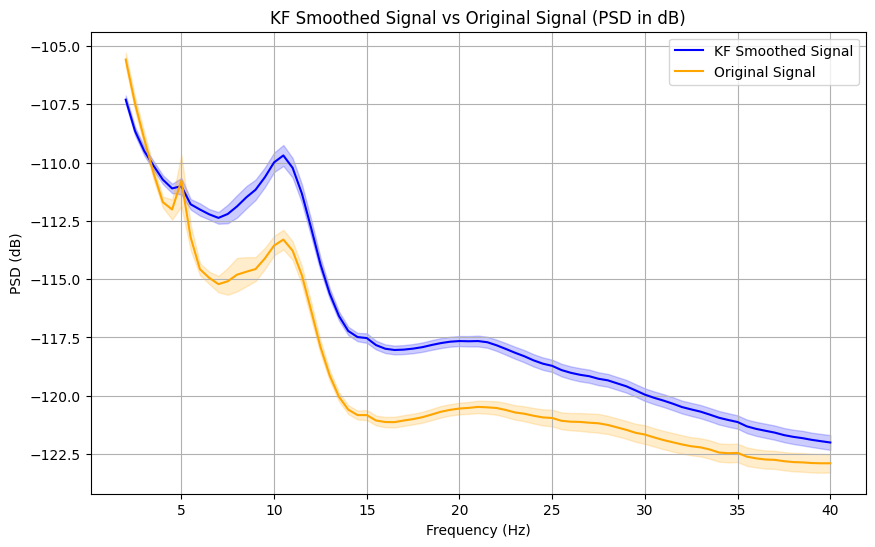

In [24]:
plt.figure(figsize=(10, 6))

# Convert PSD values to dB
mean_smoothed_db = 10 * np.log10(mean_smoothed)
sem_smoothed_db = 10 * np.log10(mean_smoothed + sem_smoothed) - mean_smoothed_db

mean_raw_db = 10 * np.log10(mean_raw)
sem_raw_db = 10 * np.log10(mean_raw + sem_raw) - mean_raw_db

# Plotting the smoothed signal
plt.plot(freqs_filtered, mean_smoothed_db, label='KF Smoothed Signal', color='blue')
plt.fill_between(
    freqs_filtered, 
    mean_smoothed_db - sem_smoothed_db, 
    mean_smoothed_db + sem_smoothed_db, 
    alpha=0.2, 
    color='blue'
)

# Plotting the original signal
plt.plot(freqs_filtered, mean_raw_db, label='Original Signal', color='orange')
plt.fill_between(
    freqs_filtered, 
    mean_raw_db - sem_raw_db, 
    mean_raw_db + sem_raw_db, 
    alpha=0.2, 
    color='orange'
)

# Labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB)')  # Updated units
plt.title('KF Smoothed Signal vs Original Signal (PSD in dB)')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
psd_raw_ns = []
psd_raw_sd = []
for i in range(1, 72):
    patient_id = f"sub-{i:02d}"
    for session, condition in zip(['1', '2'], ['normal sleep', 'sleep deprivation']):
        eeg_path = os.path.join("Sleep_dep_dataset", patient_id, "ses-" + session, "eeg", patient_id + "_ses-" + session + "_task-eyesopen_eeg.set")
        
        if os.path.exists(eeg_path):
            raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
            data = raw.get_data()

            freqs, psd = welch(data, sfreq, nperseg=sfreq * 2, axis=1)
            freq_mask = (freqs >= fmin) & (freqs <= fmax)
            freqs_filtered = freqs[freq_mask]
            psd_filtered = psd[:, freq_mask]
            mean_psd = np.mean(psd_filtered, axis=0)
  
            if condition == 'normal sleep':
                psd_raw_ns.append(mean_psd)
            else:
                psd_raw_sd.append(mean_psd)

psd_raw_ns = np.array(psd_raw_ns)
psd_raw_sd = np.array(psd_raw_sd)

mean_raw_ns = np.mean(psd_raw_ns, axis=0)
sem_raw_ns = np.std(psd_raw_ns, axis=0) / np.sqrt(psd_raw_ns.shape[0])

mean_raw_sd = np.mean(psd_raw_sd, axis=0)
sem_raw_sd = np.std(psd_raw_sd, axis=0) / np.sqrt(psd_raw_sd.shape[0])

psd_smoothed_ns = []
psd_smoothed_sd = []

features_file = "KF_smoothed_data.pkl"
with open(features_file, 'rb') as f:
    smoothed_data_dict = pickle.load(f)

for patient_session, data in smoothed_data_dict.items():
    smoothed_data = data['smoothed_data'] 
    label = data['label']  


    smoothed_data_continuous = np.concatenate(smoothed_data, axis=-1)  

  
    freqs, psd = welch(smoothed_data_continuous, sfreq, nperseg=sfreq * 2, axis=1)  
    freq_mask = (freqs >= fmin) & (freqs <= fmax)
    freqs_filtered = freqs[freq_mask]
    psd_filtered = psd[:, freq_mask]
    mean_psd = np.mean(psd_filtered, axis=0)
    
    if label == 0:  
        psd_smoothed_ns.append(mean_psd)
    else:  
        psd_smoothed_sd.append(mean_psd)

psd_smoothed_ns = np.array(psd_smoothed_ns)
psd_smoothed_sd = np.array(psd_smoothed_sd)

mean_smoothed_ns = np.mean(psd_smoothed_ns, axis=0)
sem_smoothed_ns = np.std(psd_smoothed_ns, axis=0) / np.sqrt(psd_smoothed_ns.shape[0])

mean_smoothed_sd = np.mean(psd_smoothed_sd, axis=0)
sem_smoothed_sd = np.std(psd_smoothed_sd, axis=0) / np.sqrt(psd_smoothed_sd.shape[0])

Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-01\ses-1\eeg\sub-01_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-01\ses-2\eeg\sub-01_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 113955  =      0.000 ...   227.910 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-02\ses-1\eeg\sub-02_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-02\ses-2\eeg\sub-02_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-03\ses-1\eeg\sub-03_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-03\ses-2\eeg\sub-03_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Read

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\3265498461.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-47\ses-1\eeg\sub-47_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-47\ses-2\eeg\sub-47_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-48\ses-1\eeg\sub-48_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-48\ses-2\eeg\sub-48_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-49\ses-1\eeg\sub-49_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-49\ses-2\eeg\sub-49_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Read

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\3265498461.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-52\ses-1\eeg\sub-52_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-52\ses-2\eeg\sub-52_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 182389  =      0.000 ...   364.778 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\3265498461.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-53\ses-1\eeg\sub-53_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-53\ses-2\eeg\sub-53_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-54\ses-1\eeg\sub-54_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-54\ses-2\eeg\sub-54_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-55\ses-1\eeg\sub-55_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-55\ses-2\eeg\sub-55_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Read

C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\3265498461.py:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\3265498461.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-57\ses-2\eeg\sub-57_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 125719  =      0.000 ...   251.438 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\3265498461.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-58\ses-1\eeg\sub-58_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-58\ses-2\eeg\sub-58_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 132409  =      0.000 ...   264.818 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\3265498461.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-59\ses-1\eeg\sub-59_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-59\ses-2\eeg\sub-59_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 144109  =      0.000 ...   288.218 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\3265498461.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-60\ses-1\eeg\sub-60_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 124489  =      0.000 ...   248.978 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\3265498461.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-60\ses-2\eeg\sub-60_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-61\ses-1\eeg\sub-61_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-61\ses-2\eeg\sub-61_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-62\ses-1\eeg\sub-62_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-62\ses-2\eeg\sub-62_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 141789  =      0.000 ...   283.578 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\3265498461.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-63\ses-1\eeg\sub-63_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-63\ses-2\eeg\sub-63_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-64\ses-1\eeg\sub-64_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-64\ses-2\eeg\sub-64_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-65\ses-1\eeg\sub-65_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-65\ses-2\eeg\sub-65_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 118919  =      0.000 ...   237.838 secs...


C:\Users\yaoyu\AppData\Local\Temp\ipykernel_21016\3265498461.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path, preload=True)


Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-66\ses-1\eeg\sub-66_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-66\ses-2\eeg\sub-66_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-67\ses-1\eeg\sub-67_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-67\ses-2\eeg\sub-67_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-68\ses-1\eeg\sub-68_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Reading c:\Users\yaoyu\Documents\EE675\Sleep_dep_dataset\sub-68\ses-2\eeg\sub-68_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Read

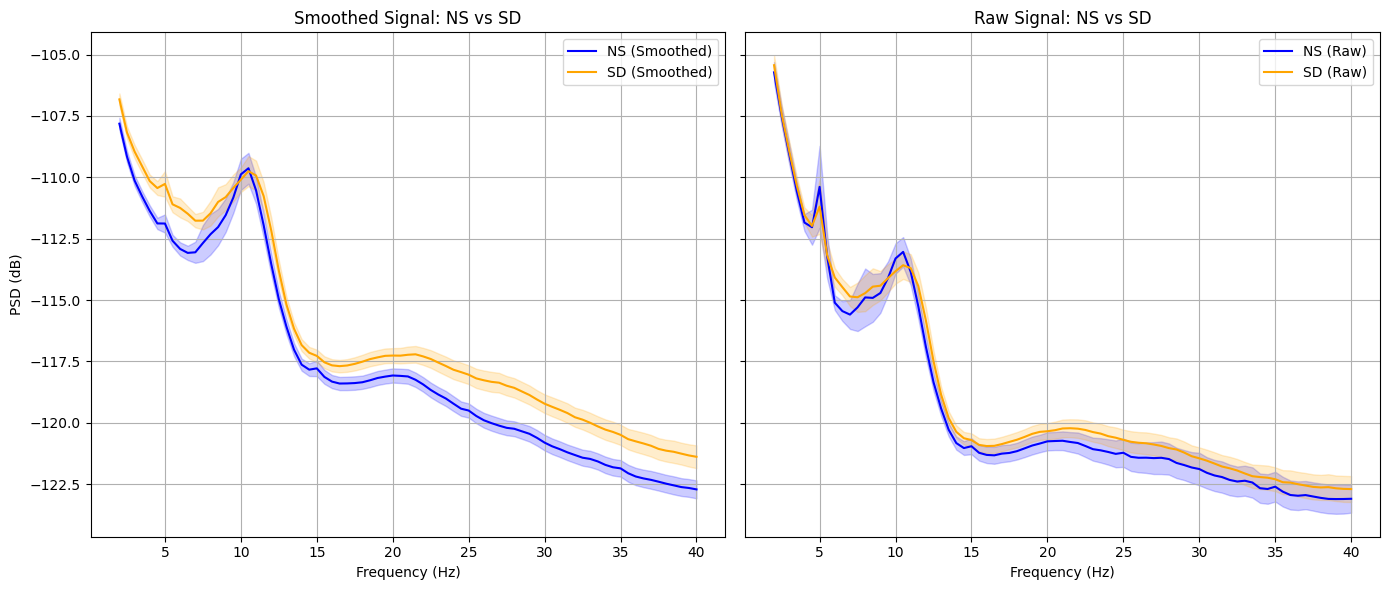

In [26]:
import matplotlib.pyplot as plt

# Convert PSD values to dB for smoothed signals
mean_smoothed_ns_db = 10 * np.log10(mean_smoothed_ns)
sem_smoothed_ns_db = 10 * np.log10(mean_smoothed_ns + sem_smoothed_ns) - mean_smoothed_ns_db

mean_smoothed_sd_db = 10 * np.log10(mean_smoothed_sd)
sem_smoothed_sd_db = 10 * np.log10(mean_smoothed_sd + sem_smoothed_sd) - mean_smoothed_sd_db

# Convert PSD values to dB for raw signals
mean_raw_ns_db = 10 * np.log10(mean_raw_ns)
sem_raw_ns_db = 10 * np.log10(mean_raw_ns + sem_raw_ns) - mean_raw_ns_db

mean_raw_sd_db = 10 * np.log10(mean_raw_sd)
sem_raw_sd_db = 10 * np.log10(mean_raw_sd + sem_raw_sd) - mean_raw_sd_db

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Smoothed signals plot
axes[0].plot(freqs_filtered, mean_smoothed_ns_db, label='NS (Smoothed)', color='blue')
axes[0].fill_between(
    freqs_filtered,
    mean_smoothed_ns_db - sem_smoothed_ns_db,
    mean_smoothed_ns_db + sem_smoothed_ns_db,
    alpha=0.2,
    color='blue'
)
axes[0].plot(freqs_filtered, mean_smoothed_sd_db, label='SD (Smoothed)', color='orange')
axes[0].fill_between(
    freqs_filtered,
    mean_smoothed_sd_db - sem_smoothed_sd_db,
    mean_smoothed_sd_db + sem_smoothed_sd_db,
    alpha=0.2,
    color='orange'
)
axes[0].set_title('Smoothed Signal: NS vs SD')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('PSD (dB)')  # Updated units
axes[0].legend()
axes[0].grid(True)

# Raw signals plot
axes[1].plot(freqs_filtered, mean_raw_ns_db, label='NS (Raw)', color='blue')
axes[1].fill_between(
    freqs_filtered,
    mean_raw_ns_db - sem_raw_ns_db,
    mean_raw_ns_db + sem_raw_ns_db,
    alpha=0.2,
    color='blue'
)
axes[1].plot(freqs_filtered, mean_raw_sd_db, label='SD (Raw)', color='orange')
axes[1].fill_between(
    freqs_filtered,
    mean_raw_sd_db - sem_raw_sd_db,
    mean_raw_sd_db + sem_raw_sd_db,
    alpha=0.2,
    color='orange'
)
axes[1].set_title('Raw Signal: NS vs SD')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
